# Metric Testing

Test different metrics (loss functions) on their relative effectiveness in evaluating the true model specification.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from regime_switching.generate.arx import VARXGenerator

## Pick specification

In [3]:
gen = VARXGenerator.random_model(
    n=2, m=0, p_max=2, 
    random_state=42
)

In [4]:
gen.endogenous.tolist(), gen.exogenous.tolist()

([0, 1], [])

In [5]:
y = gen.generate(100)

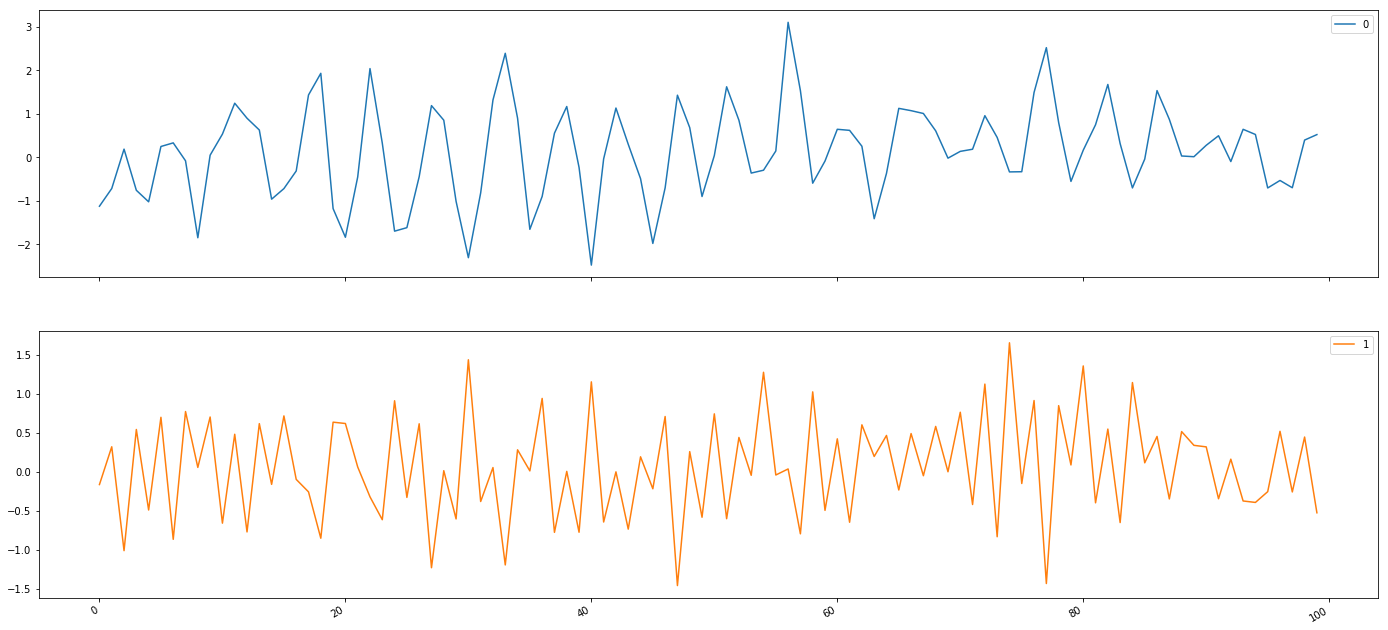

In [6]:
y.plot(subplots=True, figsize=(24, 12));

In [7]:
gen.coef_ar_df

0         1
lag                      
1   0  0.597991  0.397988
    1 -0.265972 -0.266008
2   0 -0.412875  0.799264
    1  0.401673  0.562109

In [8]:
gen.covariance

,0,1
0,0.593437,-0.129327
1,-0.129327,0.102225


## Fit a model

In [9]:
import statsmodels.api as sm

In [10]:
spec = sm.tsa.VAR(y, )

In [11]:
fitted = spec.fit(max(gen.lags))

In [12]:
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Mar, 2019
Time:                     21:03:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.18561
Nobs:                     98.0000    HQIC:                  -3.34269
Log likelihood:          -99.0923    FPE:                  0.0317709
AIC:                     -3.44938    Det(Omega_mle):       0.0287612
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.022360         0.069986            0.319           0.749
L1.0          0.619631         0.069547            8.910           0.000
L1.1          0.662675         0.139655            4.745           0.000
L2.0         -0.429070 

In [13]:
fitted.coefs

array([[[ 0.61963067,  0.66267498],
        [-0.28492062, -0.28740187]],

       [[-0.42907035,  0.89750992],
        [ 0.44027015,  0.57387408]]])

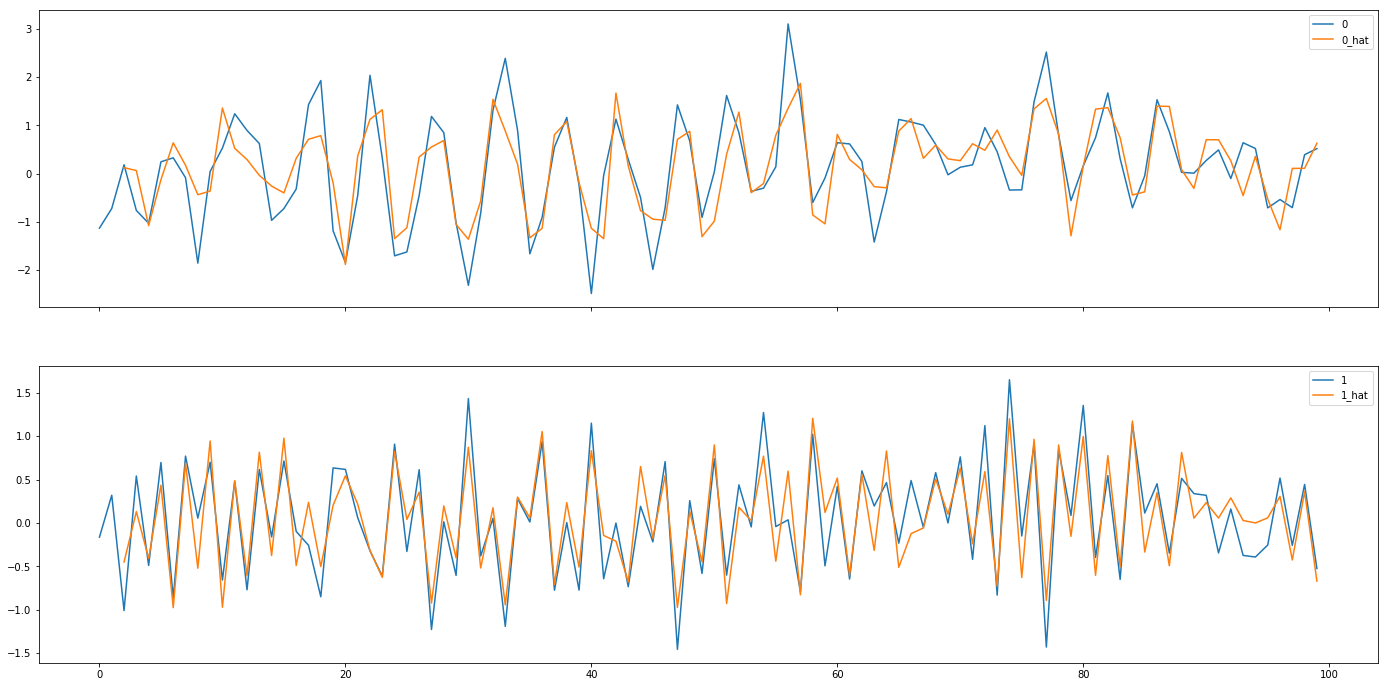

In [14]:
y_hat = fitted.fittedvalues
y_hat.columns = ['{}_hat'.format(i) for i in range(2)]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
for i in range(2):
    y[[i]].plot(ax=ax[i]);
    y_hat.iloc[:, i:i+1].plot(ax=ax[i]);